In [1]:
# do the imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
from datetime import datetime
sns.set()

In [2]:
# import pytorch specific utils

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
# get the dataset

train_dataset = datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw
Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw
Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw
Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw
Processing...

Done!


In [5]:
# get the dataset shape and the number of targets

image_shape = train_dataset.data.shape
no_of_targets = len(np.unique(train_dataset.targets.numpy()))
print(f"Each dataset is of shape: {image_shape[-1]}")
print(f"Number of classes in the dataset: {no_of_targets}")
train_dataset.data.shape

Each dataset is of shape: 28
Number of classes in the dataset: 10


torch.Size([60000, 28, 28])

In [6]:
# define the model
class fmnist_net(nn.Module):
    def __init__(self, no_of_targets):
        super(fmnist_net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,
                      stride=2),
            nn.ReLU()
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2*2*128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, no_of_targets)
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [7]:
# instantiate the model\
model = fmnist_net(no_of_targets)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Device Found: {device}")

Device Found: cpu


In [8]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [10]:
epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [11]:
# start the training process
# stuff to store
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

train_accus = np.zeros(epochs)
test_accus = np.zeros(epochs)

for epoch in range(epochs):
    t0 = datetime.now()
    train_batch_losses = []
    test_batch_losses = []

    train_batch_accus = []
    test_batch_accus = []

    print("Training Network.....")
    for inputs, targets in train_loader:
        print(f"INPUTS: {inputs.shape}")

        #move data to gpu
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the grad
        optimizer.zero_grad()

        # forwards pass and get losses
        logits = model(inputs)
        train_batch_loss = criterion(logits, targets)
        train_batch_losses.append(train_batch_loss.item())

        # get accus
        # convert from logits to probabilities
        train_logit_probs = torch.exp(logits) / \
                            torch.sum(torch.exp(logits), dim=1).view(-1, 1)
        probs, indices = torch.topk(train_logit_probs, k=1, dim=1,)
        equals = targets.view(-1, 1) == indices
        train_batch_accu = np.mean(equals.detach().cpu().numpy())
        train_batch_accus.append(train_batch_accu)

        # BACKSTEP
        train_batch_loss.backward()
        optimizer.step()


    # Now validate
    print("Evaluating Network.....")
    with torch.no_grad():
        for inputs, targets in test_loader:

            #move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)

            # forwards pass and get losses
            logits = model(inputs)
            test_batch_loss = criterion(logits, targets)
            test_batch_losses.append(test_batch_loss.item())

            # get accus
            # convert from logits to probabilities
            test_logit_probs = torch.exp(logits) / \
                                torch.sum(torch.exp(logits), dim=1).view(-1, 1)
            probs, indices = torch.topk(test_logit_probs, k=1, dim=1,)
            equals = targets.view(-1, 1) == indices
            test_batch_accu = np.mean(equals.cpu().numpy())
            test_batch_accus.append(test_batch_accu)

    print("=" * 50)
    # now getting out to the next epoch - all batches done - store epoch
    # loss and accus
    train_losses[epoch] = np.mean(train_batch_losses)
    test_losses[epoch] = np.mean(test_batch_losses)
    train_accus[epoch] = np.mean(train_batch_accus)
    test_accus[epoch] = np.mean(test_batch_accus)


    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}  TrainLoss: {train_losses[epoch]:0.3f}  "
              f"TestLoss: {test_losses[epoch]:0.3f}")
        print(f"TrainAcc: {train_accus[epoch]:0.3f}  TestAccus: "
              f"{test_accus[epoch]}:0.3f")
        print(f"Duration: {datetime.now() - t0}")
        print("=" * 50)

Training Network.....
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Size([128, 1, 28, 28])
INPUTS: torch.Si

In [33]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [34]:
# evaluate the network for confusion matrix and classification report
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy().reshape(-1, 1)
p_test = np.array([]).reshape(0, 1)

with torch.no_grad():
        for inputs, targets in test_loader:
            
            #move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)

            # forwards pass and get losses
            logits = model(inputs)

            # get accus
            # convert from logits to probabilities
            test_logit_probs = torch.exp(logits) / \
                                torch.sum(torch.exp(logits), dim=1).view(-1, 1)
            probs, indices = torch.topk(test_logit_probs, k=1, dim=1,)
            equals = targets.view(-1, 1) == indices
            
            # i are indices with highest probs predicted by the network
            i = indices.cpu().numpy()
            p_test = np.concatenate((p_test, i))

In [40]:
# evaluate the network - get classification matrix
from sklearn.metrics import classification_report, confusion_matrix
classNames = '''T-shirt/top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Ankleboot'''.split(" ")
print (classification_report(y_test,p_test, target_names=classNames))


              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.86      0.84      1000
       Dress       0.91      0.88      0.90      1000
        Coat       0.85      0.81      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.70      0.70      0.70      1000
     Sneaker       0.95      0.95      0.95      1000
         Bag       0.97      0.97      0.97      1000
   Ankleboot       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



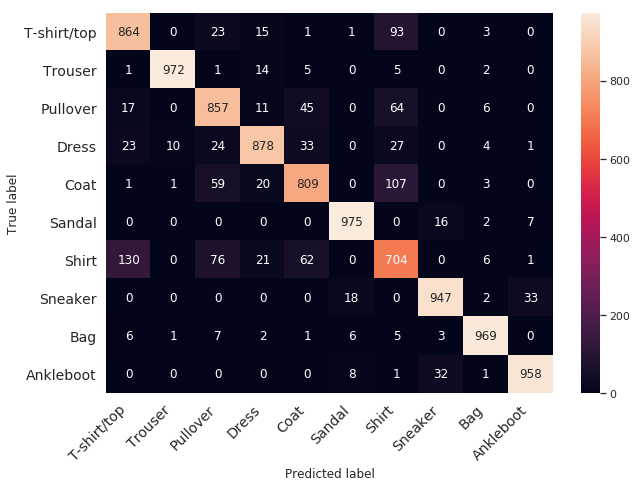

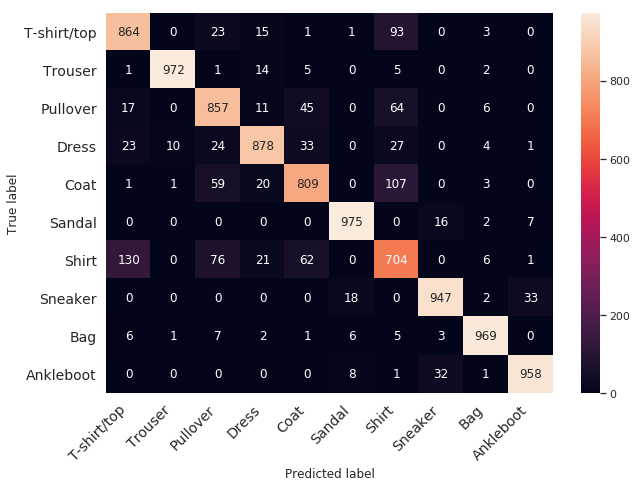

In [46]:
# draw the confusion matrix
cm = confusion_matrix(y_test, p_test)
print_confusion_matrix(cm, class_names=classNames)

Actual: Pullover but Predicted: Coat


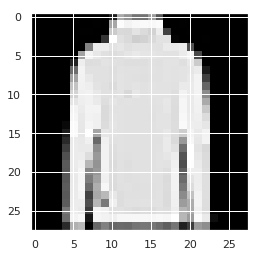

In [90]:
# show some misclassified examples
# y_test contains actual label, p_test contains predicted labels

missmatch_indices = np.nonzero(p_test != y_test)[0]
x_test = test_dataset.data.numpy()

# grab a mismatched x
idx = np.random.choice(missmatch_indices)
x_miss = x_test[idx]
miss_label = int(p_test[idx][0])
actual_label = int(y_test[idx][0])

# now plot
print(f"Actual: {classNames[actual_label]} but Predicted: {classNames[miss_label]}")
plt.imshow(x_miss, cmap='gray');